In [2]:
import torch
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans
from statsmodels.discrete.discrete_model import Probit
import patsy
import matplotlib.pylab as plt
import tqdm
import itertools

ax = np.newaxis

Make sure you have installed the pygfe package. You can simply call `pip install pygfe` in the terminal or call the magic command `!pip install pygfe` from within the notebook. If you are using the binder link, then `pygfe` is already installed. You can import the package directly.

In [3]:
import pygfe as gfe

# A simple model of wage and participation

\begin{align*}
Y^*_{it} & = \alpha_i + \epsilon_{it} \\
D_{it} &= 1\big[ u(\alpha_i) \geq c(D_{it-1}) + V_{it}  \big] \\
Y_{it} &= D_{it} Y^*_{it} \\
\end{align*}

where we use 

$$u(\alpha) = \frac{e^{(1-\gamma) \alpha } -1}{1-\gamma}$$

and use as initial conditions $D_{i1} = 1\big[ u(\alpha_i) \geq c(1) + V_{i1}  \big]$.

In [4]:
def dgp_simulate(ni,nt,gamma=2.0,eps_sd=1.0):
    """ simulates according to the model """
    alpha = np.random.normal(size=(ni))
    eps   = np.random.normal(size=(ni,nt))
    v     = np.random.normal(size=(ni,nt))
    
    # non-censored outcome
    W = alpha[:,ax] + eps*eps_sd
    
    # utility
    U = (np.exp( alpha * (1-gamma)) - 1)/(1-gamma)
    U = U - U.mean()
    
    # costs
    C1 = -1; C0=0;
    
    # binary decision
    Y = np.ones((ni,nt))
    Y[:,0] = U.squeeze() > C1 + v[:,0]
    for t in range(1,nt): 
        Y[:,t] = U > C1*Y[:,t-1] + C0*(1-Y[:,t-1]) + v[:,t]
    W =  W * Y
        
    return(W,Y)

# Estimating the model

We show the steps to estimating the model. Later on, we will run a Monte-Carlo Simulation.

We simulate from the DGP we have defined.

In [12]:
ni = 1000
nt = 50
Y,D = dgp_simulate(ni,nt,2.0)

## Step 1: grouping observations

We group individuals based on their outcomes. We consider as moments the average value of $Y$ and the average value of $D$. We give our gfe function the $t$ sepcific values so that it can compute the within individual variation. This is a measure used to pick the nubmer of groups.

The `group` function chooses the number of groups based on the rule described in the paper. 

In [13]:
# we create the moments
# this has dimension ni x nt x nm 
M_itm = np.stack([Y,D],axis=2)

# we use our sugar function to get the groups
G_i,_  = gfe.group(M_itm)

print("Number of groups = {:d}".format(G_i.max()))

Number of groups = 11


We can plot the grouping:

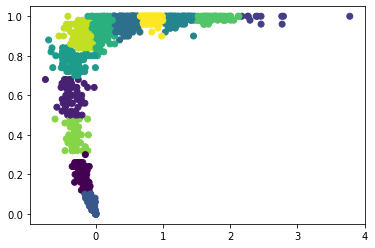

In [14]:
dd = pd.DataFrame({'Y':Y.mean(1),'G':G_i,'D':D.mean(1)})
plt.scatter(dd.Y,dd.D,c=dd.G*1.0)
plt.show()

## Step 2: Estimate the likelihood model with group specific parameters

In the model we proposed, this second step is a probit. We can then directly use python probit routine with group dummies.

In [15]:
ni,nt = D.shape

# next we minimize using groups as FE
dd = pd.DataFrame({
    'd': D[:,range(1,nt)].flatten(), 
    'dl':D[:,range(nt-1)].flatten(), 
    'gi':np.broadcast_to(G_i[:,ax], (ni,nt-1)).flatten()})

yv,Xv = patsy.dmatrices("d ~ 0 + dl + C(gi)", dd, return_type='matrix')
mod = Probit(dd['d'], Xv)
res = mod.fit(maxiter=2000,method='bfgs') 

print("Estimated cost parameters = {:.3f}".format(res.params[-1]))

Optimization terminated successfully.
         Current function value: 0.228267
         Iterations: 87
         Function evaluations: 88
         Gradient evaluations: 88
Estimated cost parameters = 0.985


## Step 2 (alternative implementation): Pytorch and auto-diff

We next write down a likelihood that we want to optimize. Instead of using the Python routine for the Probit, we make use of automatic differentiation from PyTorch. This makes it easy to modify the estimating model to accomodate for less standard likelihoods! 

We create a class which initializes the parameters in the `__init__` method and computes the loss in the `loss` method. We will see later how we can use this to define a fixed effect estimator. 

In [16]:
class GrpProbit:

    # initialize parameters and data
    def __init__(self,D,G_i):
        # define parameters and tell PyTorch to keep track of gradients
        self.alpha = torch.tensor( np.ones(G_i.max()+1), requires_grad=True)
        self.cost  = torch.tensor( np.random.normal(1), requires_grad=True)
        self.params = [self.alpha,self.cost]
        
        # predefine some components
        ni,nt     = D.shape
        self.ni   = ni
        self.G_i  = G_i
        self.Dlag = torch.tensor(D[:,range(0,nt-1)])
        self.Dout = torch.tensor(D[:,range(1,nt)])
        self.N    = torch.distributions.normal.Normal(0,1)
        
    # define our loss function
    def loss(self):
        Id = self.alpha[self.G_i].reshape(self.ni,1) + self.cost * self.Dlag
        lik_it = self.Dout * torch.log( torch.clamp( self.N.cdf( Id ), min=1e-7)) +  \
                    (1-self.Dout)*torch.log( torch.clamp( self.N.cdf( -Id ), min=1e-7) )
        return(- lik_it.mean())


In [17]:
# initialize the model with groups and estimate it
model = GrpProbit(D,G_i)
gfe.train(model)

print("Estimated cost parameters = {:.3f}".format(model.params[1]))

Estimated cost parameters = 0.985


## Use PyTorch to estimate Fixed Effect version

Since Pytorch makes use of efficient automatic differentiation, we can use it with many variables. This allows us to give each individual their own group, effectivily estimating a fixed-effect model.

In [18]:
model_fe = GrpProbit(D,np.arange(ni))
gfe.train(model_fe)

print("Estimated cost parameters FE = {:.3f}".format(model_fe.params[1]))

Estimated cost parameters FE = 0.901


# Monte-Carlo

We finish with running a short Monte-Carlo exercise.

In [154]:
all = []
import itertools

ll = list(itertools.product(range(50), [10,20,30,40]))
for r, nt in tqdm.tqdm(ll):
    ni = 1000
    gamma =2.0
    
    Y,D = dgp_simulate(ni,nt,gamma)
    
    M_itm = np.stack([Y,D],axis=2)
    G_i,_  = blm2.group(M_itm,scale=True)

    model_fe = GrpProbit(D,np.arange(ni))
    gfe.train(model_fe)
    
    model_gfe = GrpProbit(D,G_i)
    gfe.train(model_gfe)
    
    all.append({
        'c_fe' : model_fe.params[1].item(), 
        'c_gfe': model_gfe.params[1].item(), 
        'ni':ni,
        'nt':nt,
        'gamma':gamma, 
        'ng':G_i.max()+1})

    

100%|██████████| 200/200 [19:18<00:00,  5.79s/it]


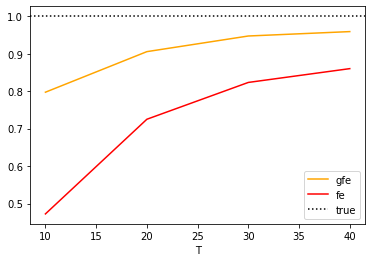

In [156]:
df = pd.DataFrame(all)
df2 = df.groupby(['ni','nt','gamma']).mean().reset_index()
plt.plot(df2['nt'],df2['c_gfe'],label="gfe",color="orange")
plt.plot(df2['nt'],df2['c_fe'],label="fe",color="red")
plt.axhline(1.0,label="true",color="black",linestyle=":")
plt.xlabel("T")
plt.legend()
plt.show()

In [135]:
df.groupby(['ni','nt','gamma']).mean()

c_fe     c_gfe     ng
ni   nt gamma                           
1000 10 2.0   -0.474319 -0.793172   6.04
     20 2.0   -0.727105 -0.906604   8.18
     30 2.0   -0.817691 -0.942789   9.86
     40 2.0   -0.861104 -0.961328  11.28